In [1]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil
import caffe2.python.predictor.predictor_exporter as pe

from caffe2.python import core,model_helper,net_drawer,workspace,visualize,brew

In [ ]:
core.GlobalInit(['caffe2','--caff2_log_level=0'])
print('Necessities imported')

In [3]:
def DownloadResource(url,path):
    import requests,zipfile,StringIO
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")
    
current_folder = os.path.join(os.path.expanduser('~'),'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print("Your data folder was not found! This was generated:", data_folder)
    
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True
    
if db_missing:
    print("one or both of the MNIST lmdb dbs not found!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset, Please download it manally from ", db_url)
        print("Unzip it and place the two database folder here:", data_folder)
        raise ex
        
if os.path.exists(root_folder):
    print("Looks like you ran this before, so we need to clean those old files...")
    shutil.rmtree(root_folder)
    
os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

print("training data folder:", data_folder)
print("workspace root folder:", root_folder)

('Your data folder was not found! This was generated:', '/root/caffe2_notebooks/tutorial_data/mnist')
one or both of the MNIST lmdb dbs not found!
Completed download and extraction.
('training data folder:', '/root/caffe2_notebooks/tutorial_data/mnist')
('workspace root folder:', '/root/caffe2_notebooks/tutorial_files/tutorial_mnist')


In [11]:
def AddInput(model, batch_size, db, db_type):
    data_uinit8, label = model.TensorProtosDBInput(
        [],["data_uint8","label"], batch_size=batch_size,
        db=db, db_type=db_type
    )
    data = model.Cast(data_uinit8,"data",to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data,data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data,label

In [12]:
def AddLeNetModel(model, data):
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50*4*4, dim_out=500)
    fc3 = brew.relu(model, fc3, fc3)
    pred = brew.fc(model, fc3, 'pred', 500, 10)
    softmax = brew.softmax(model, pred, 'softmax')
    return softmax

In [13]:
def AddAcuracy(model, softmax, label):
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

In [33]:
def AddTrainingOperator(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax,label], 'xent')
    loss = model.AveragedLoss(xent, "loss")
    AddAcuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    ITER = brew.iter(model,"iter")
    LR = model.LearningRate(ITER, "LR", base_lr=-0.1, policy="step", stepsize=1, gamma=0.999)
    # ONE is used in the gradient update
    ONE = model.param_init_net.ConstantFill([],"ONE", shape=[1], value=1.0)
    for param in model.params:
        param_grad = model.param_to_grad[param]
        model.WeightedSum([param, ONE, param_grad, LR], param)

In [34]:
def AddBookeepingOperator(model):
    model.Print("accuracy", [], to_file=1)
    model.Print("loss", [], to_file=1)
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)

In [35]:
arg_scope = {"order":"NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train",arg_scope=arg_scope)
data, label = AddInput(train_model, batch_size=64, db=os.path.join(data_folder,"mnist-train-nchw-lmdb"),db_type="lmdb")
softmax = AddLeNetModel(train_model,data)
AddTrainingOperator(train_model,softmax,label)
AddBookeepingOperator(train_model)

test_model = model_helper.ModelHelper(name="mnist_test",arg_scope=arg_scope,init_params=False)
data,label = AddInput(test_model, batch_size=100, db=os.path.join(data_folder,"mnist-test-nchw-lmdb"),db_type="lmdb")
softmax = AddLeNetModel(test_model,data)
AddAcuracy(test_model, softmax, label)

deploy_model = model_helper.ModelHelper(name="mnist_deploy", arg_scope=arg_scope, init_params=False)
AddLeNetModel(deploy_model, "data")

BlobReference("softmax")

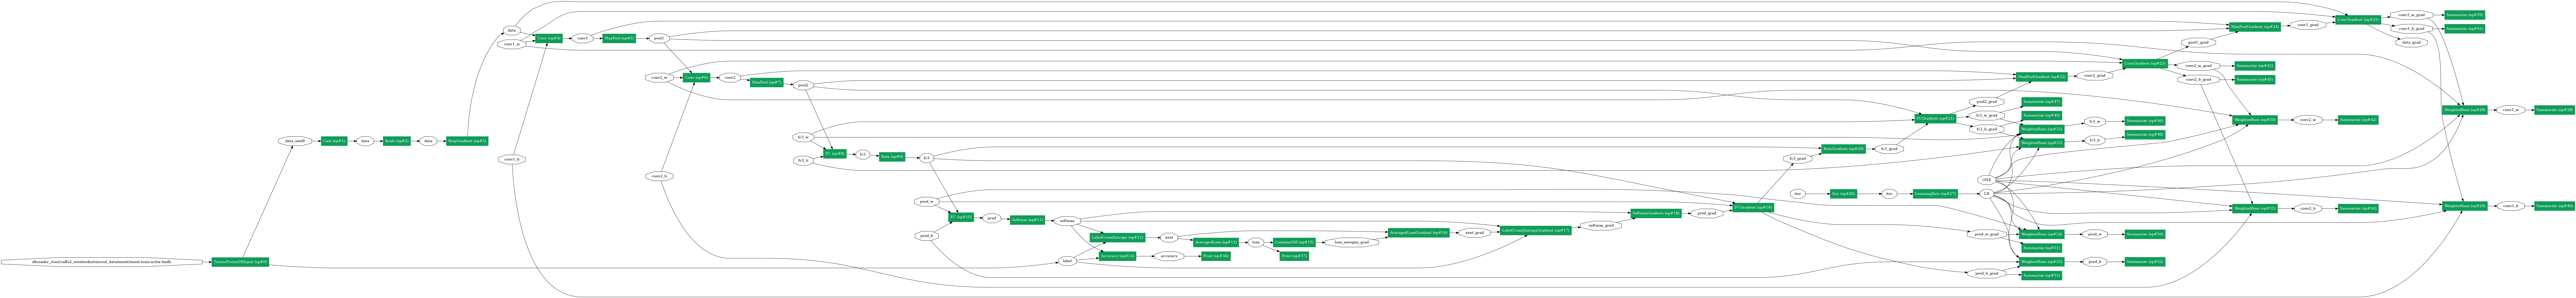

In [36]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

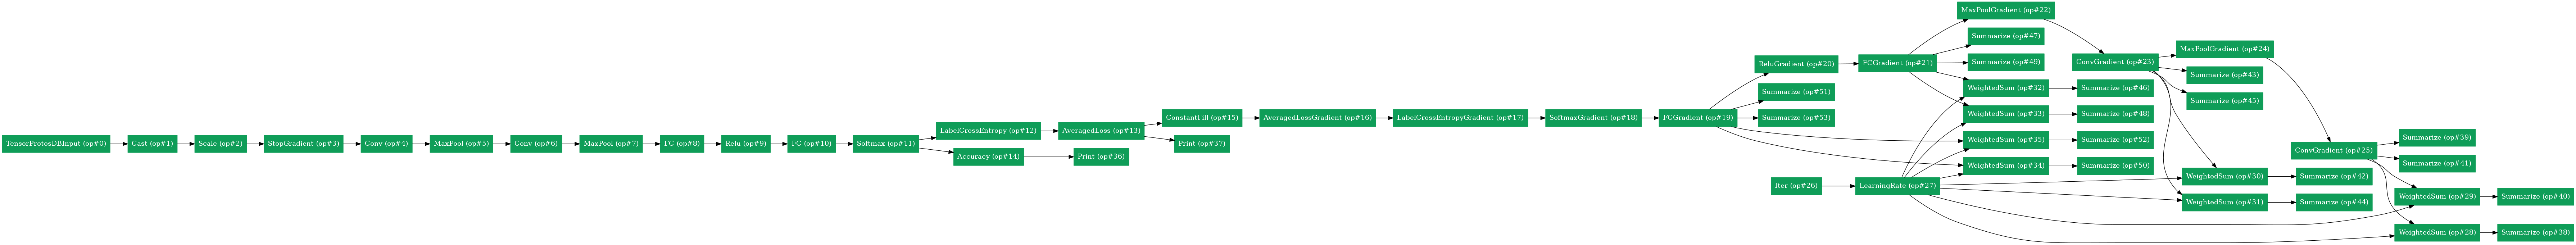

In [37]:
graph = net_drawer.GetPydotGraphMinimal(train_model.net.Proto().op,"mnist",rankdir="LR", minimal_dependency=True)
display.Image(graph.create_png(), width=800)

In [38]:
with open(os.path.join(root_folder, "train_net.pbtxt"), "w") as fid:
    fid.write(str(train_model.net.Proto()))
with open(os.path.join(root_folder, "train_init_net.pbtxt"), "w") as fid:
    fid.write(str(train_model.param_init_net.Proto()))
with open(os.path.join(root_folder,"test_net.pbtxt"), "w") as fid:
    fid.write(str(test_model.net.Proto()))
with open(os.path.join(root_folder,"test_init_net.pbtxt"), "w") as fid:
    fid.write(str(test_model.param_init_net.Proto()))
with open(os.path.join(root_folder, "deploy_net.pbtxt"), "w") as fid:
    fid.write(str(deploy_model.net.Proto()))
print("Protocol buffers files hava been created in your root folder ", root_folder)

('Protocol buffers files hava been created in your root folder ', '/root/caffe2_notebooks/tutorial_files/tutorial_mnist')


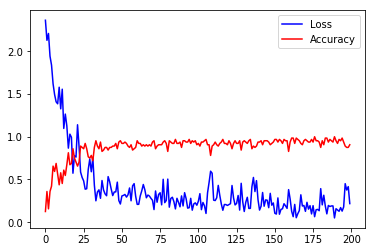

In [39]:
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)

total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.FetchBlob('accuracy')
    loss[i] = workspace.FetchBlob("loss")
    
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(("Loss","Accuracy"), loc="upper right")